In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
from PIL import Image
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Input,ZeroPadding2D,BatchNormalization,Activation
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.layers.experimental import preprocessing


from sklearn.metrics import classification_report

In [2]:
# the r in front of the string converts it to a raw string
folder_path = r"C:/Users/Darin Tsui/Documents/COGS 118b/Proj"
No_Tumor_Img = os.listdir(folder_path + '/no/')
Tumor_Img = os.listdir(folder_path + '/yes/')

In [3]:
Classes = {'no':0, 'yes':1}

In [4]:
X = []
y = []
for i in Classes:
    path = r"C:/Users/Darin Tsui/Documents/COGS 118b/Proj/"+i
    for j in os.listdir(path):
        img = cv2.imread(path+'/'+j, 0)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # use the process function to crop the brain and ignore the unnecessary rest part of the image
        
        # resize image
        img = cv2.resize(img, (128,128),interpolation=cv2.INTER_CUBIC)
        # normalize values
        #img = img / 255  #-->Apply normalization because we want pixel values to be scaled to the range 0-1
        X.append(img)
        y.append(Classes[i])

In [5]:
no_image_pixels = []
yes_image_pixels = []
for j in range(len(y)):
    if y[j] == 0:
        no_image_pixels.append(X[j])
    else:
        yes_image_pixels.append(X[j])

In [6]:
# Convert to numpy array 
no_image_pixels_array = np.asarray(no_image_pixels)
yes_image_pixels_array = np.asarray(yes_image_pixels)
no_image_pixels_array = no_image_pixels_array.reshape(98,16384)
yes_image_pixels_array = yes_image_pixels_array.reshape(155,16384)

In [7]:
# Perform PCA on yes's and no's 
X_no_train, X_no_test = train_test_split(no_image_pixels_array, test_size = 0.20, random_state = 69)
X_no_test = X_no_test.reshape(len(X_no_test),128,128)
print(X_no_test.shape)
X_no_train = X_no_train.T
print(X_no_train.shape)

X_yes_train, X_yes_test = train_test_split(yes_image_pixels_array, test_size = 0.20, random_state = 69)
print(X_yes_test.shape)
X_yes_test = X_yes_test[0:len(X_yes_test),:]
X_yes_test = X_yes_test.reshape(len(X_yes_test),128,128)
print(X_yes_test.shape)
X_yes_train = X_yes_train.T
print(X_yes_train.shape)

# y train, binary option tumor or no tumor
y_no = np.asarray(y[0:98])
y_yes = np.asarray(y[99:254])
y_no_train, y_no_test = train_test_split(y_no, test_size = 0.20, random_state = 12)
y_yes_train, y_yes_test = train_test_split(y_yes, test_size = 0.20, random_state = 12)
print(y_no_test.shape)
print(y_yes_test.shape)

(20, 128, 128)
(16384, 78)
(31, 16384)
(31, 128, 128)
(16384, 124)
(20,)
(31,)


In [8]:
# Standardization function
def standardize(X):
    # Calculate the mean of each column mu
    mu = np.mean(X,axis=0)
    
    # Subtract the mean from X
    X = X - mu
    
    # Calculate standard deviation of each column
    std = np.std(X,axis=0)
    
    # Handle zero standard deviation case
    std_filled = std.copy()
    std_filled[std==0] = 1.0
    
    # Calculate standardized X
    X_bar = (X-mu)/std_filled
    
    return X_bar, mu, std


In [9]:
# Function to calculate eigenvectors and eigenvalues
def eig(S):
    eig_vec, eig_val = np.linalg.eigh(S)
    # sorting eigenvalues in decreasing order
    # np.argsort returns indices of positions 
    sorted_eig = np.argsort(-eig_val)
    eig_val = eig_val[sorted_eig]
    eig_vec = eig_vec[sorted_eig]
    
    return (eig_vec, eig_val)
    

In [10]:
# Function to calculate projection matrix for reconstruction
def projection(A):
    M = A @ A.T
    return M

In [11]:
## Implement PCA
def PCA(X,mu):
    # Calculate the covariance matrix
    dim = np.shape(X)
    avg = np.tile(np.array([X.mean(axis=1)]).T, (1,dim[1])) 
    Z = X - avg
    N = dim[1]
    cov_matrix = Z.T.dot(Z) / N
    
    # Find eigenvalue and eigenvectors of covariance matrix
    eig_vecs, eig_vals = eig(cov_matrix)
    
    # Select specific eigenvectors
    U = Z.dot(eig_vecs)
    U = U / U.max(axis=0)
    return U

In [12]:
no_pixel_mu = X_no_train.mean().mean()
yes_pixel_mu = X_yes_train.mean().mean()
x_no_reconstruction = PCA(X_no_train, no_pixel_mu)
x_yes_reconstruction = PCA(X_yes_train, yes_pixel_mu)
x_no_reconstruction.T.shape
x_no_reconstruction = x_no_reconstruction.reshape(len(x_no_reconstruction.T),128,128)
x_no_reconstruction = x_no_reconstruction.reshape(-1,128,128,1)

x_yes_reconstruction = x_yes_reconstruction.reshape(len(x_yes_reconstruction.T),128,128)
x_yes_reconstruction = x_yes_reconstruction.reshape(-1,128,128,1)
x_yes_reconstruction.shape
X_yes_test.shape

(31, 128, 128)

In [13]:
# CNN Model

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(128,128,1)),
    tf.keras.layers.Conv2D(32,(4,4),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),
                              padding='valid'),
    tf.keras.layers.Conv2D(32,(4,4),activation='relu'),
    tf.keras.layers.Conv2D(16,3,activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 32)      32800     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 32)        16416     
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                    

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Separate PCA components into 2 components, 10 components, 30 components, and all components

x_no_reconstruction_2 = x_no_reconstruction[0:2,:,:]
x_yes_reconstruction_2 = x_yes_reconstruction[0:2,:,:]
y_no_train_2 = y_no_train[0:2]
y_yes_train_2 = y_yes_train[0:2]

x_no_reconstruction_10 = x_no_reconstruction[0:10,:,:]
x_yes_reconstruction_10 = x_yes_reconstruction[0:10,:,:]
y_no_train_10 = y_no_train[0:10]
y_yes_train_10 = y_yes_train[0:10]

x_no_reconstruction_30 = x_no_reconstruction[0:30,:,:]
x_yes_reconstruction_30 = x_yes_reconstruction[0:30,:,:]
y_no_train_30 = y_no_train[0:30]
y_yes_train_30 = y_yes_train[0:30]

x_no_reconstruction_all = x_no_reconstruction
x_yes_reconstruction_all = x_yes_reconstruction
y_no_train_all = y_no_train
y_yes_train_all = y_yes_train



# Combine training and test sets
x_reconstruction_2 = np.concatenate((x_no_reconstruction_2, x_yes_reconstruction_2), axis=0)
y_train_2 = np.concatenate((y_no_train_2, y_yes_train_2), axis=0)

x_reconstruction_10 = np.concatenate((x_no_reconstruction_10, x_yes_reconstruction_10), axis=0)
y_train_10 = np.concatenate((y_no_train_10, y_yes_train_10), axis=0)

x_reconstruction_30 = np.concatenate((x_no_reconstruction_30, x_yes_reconstruction_30), axis=0)
y_train_30 = np.concatenate((y_no_train_30, y_yes_train_30), axis=0)

x_reconstruction_all = np.concatenate((x_no_reconstruction_all, x_yes_reconstruction_all), axis=0)
y_train_all = np.concatenate((y_no_train_all, y_yes_train_all, [1]), axis=0)

X_test = np.concatenate((X_no_test, X_yes_test), axis=0)
y_test = np.concatenate((y_no_test, y_yes_test), axis=0)

In [16]:
# Using only 2 PCA components
x_reconstruction = x_reconstruction_2
y_train = y_train_2

model.fit(x=x_reconstruction, y=y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.6915 - accuracy: 0.7500 - val_loss: 5.3863 - val_accuracy: 0.6078
Epoch 2/10
1/1 [==============================] - 1s 797ms/step - loss: 0.6600 - accuracy: 0.7500 - val_loss: 7.1565 - val_accuracy: 0.6078
Epoch 3/10
1/1 [==============================] - 1s 682ms/step - loss: 0.6176 - accuracy: 1.0000 - val_loss: 10.2932 - val_accuracy: 0.6078
Epoch 4/10
1/1 [==============================] - 1s 678ms/step - loss: 0.5609 - accuracy: 1.0000 - val_loss: 17.2745 - val_accuracy: 0.6078
Epoch 5/10
1/1 [==============================] - 1s 634ms/step - loss: 0.4889 - accuracy: 1.0000 - val_loss: 18.7089 - val_accuracy: 0.6078
Epoch 6/10
1/1 [==============================] - 1s 627ms/step - loss: 0.4035 - accuracy: 1.0000 - val_loss: 6.5718 - val_accuracy: 0.3922
Epoch 7/10
1/1 [==============================] - 1s 634ms/step - loss: 0.2985 - accuracy: 1.0000 - val_loss: 70.6549 - val_accuracy: 0.3922
Epoch 8/10
1/1 [===

In [17]:
def plot_metrics(history, cmpts):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy using {:.0f} PCA Components'.format(cmpts))
    plt.legend()
    plt.xlabel('Accuracy (%)')
    plt.ylabel('Number of Epochs')
    plt.show()

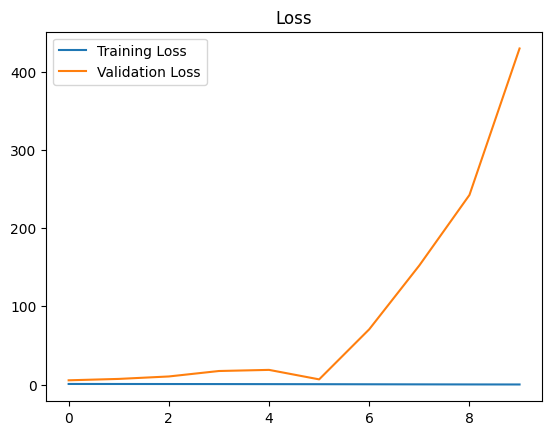

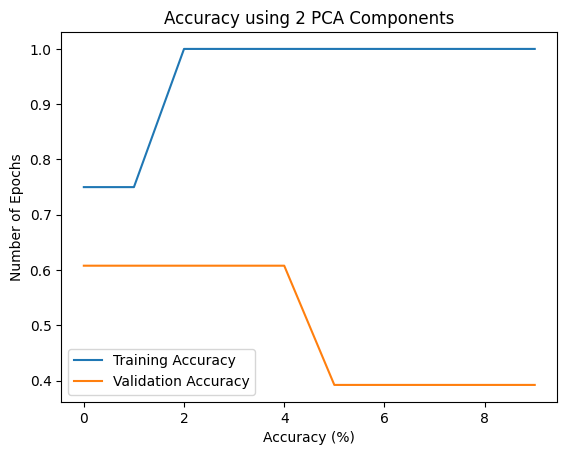

Accuracy using 2 PCA Components: 0.39%


In [18]:
cmpts = 2
history = model.history.history
acc = last = next(reversed(history.values()))
model_loss=pd.DataFrame(model.history.history)
plot_metrics(history, cmpts)
print("Accuracy using {:.0f} PCA Components: {:.2f}%".format(cmpts, acc[-1]))

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# Using only 10 PCA components
x_reconstruction = x_reconstruction_10
y_train = y_train_10

model.fit(x=x_reconstruction, y=y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.5451 - accuracy: 0.7500 - val_loss: 189.5549 - val_accuracy: 0.6078
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 2.2221 - accuracy: 0.5000 - val_loss: 46.8648 - val_accuracy: 0.6078
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.9549 - accuracy: 0.6000 - val_loss: 167.8323 - val_accuracy: 0.3922
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.2977 - accuracy: 0.9500 - val_loss: 290.4506 - val_accuracy: 0.3922
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.5065 - accuracy: 0.7500 - val_loss: 319.6630 - val_accuracy: 0.3922
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.6318 - accuracy: 0.6000 - val_loss: 275.9340 - val_accuracy: 0.3922
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.5946 - accuracy: 0.6000 - val_loss: 204.4564 - val_accuracy: 0.3922
Epoch 8/10
1/1 [============

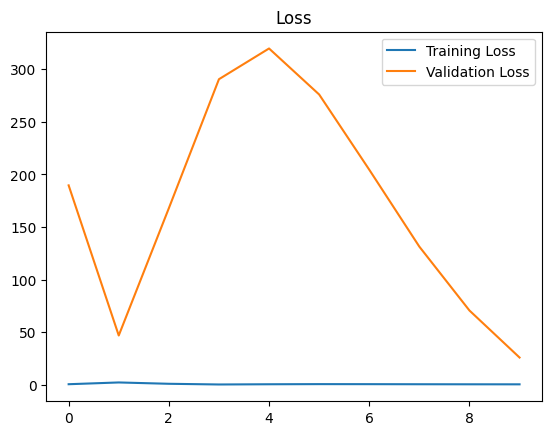

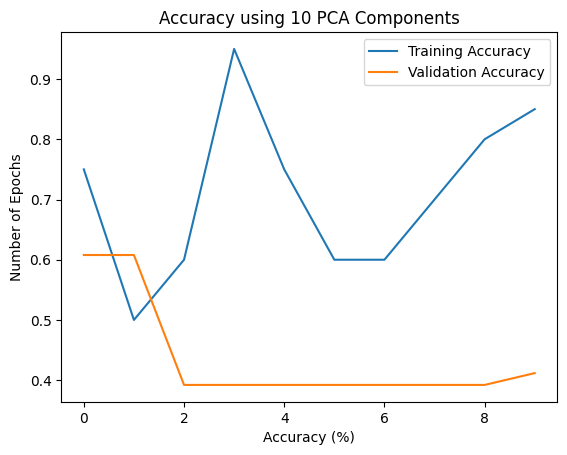

Accuracy using 10 PCA Components: 0.41%


In [21]:
cmpts = 10
history = model.history.history
acc = last = next(reversed(history.values()))
model_loss=pd.DataFrame(model.history.history)
plot_metrics(history, cmpts)
print("Accuracy using {:.0f} PCA Components: {:.2f}%".format(cmpts, acc[-1]))

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# Using only 30 PCA components
x_reconstruction = x_reconstruction_30
y_train = y_train_30

model.fit(x=x_reconstruction, y=y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
2/2 [==============================] - 7s 2s/step - loss: 0.4844 - accuracy: 0.8333 - val_loss: 54.4006 - val_accuracy: 0.3922
Epoch 2/10
2/2 [==============================] - 4s 2s/step - loss: 0.3050 - accuracy: 0.8333 - val_loss: 298.6273 - val_accuracy: 0.3922
Epoch 3/10
2/2 [==============================] - 4s 2s/step - loss: 0.1744 - accuracy: 0.9167 - val_loss: 4.4630 - val_accuracy: 0.7647
Epoch 4/10
2/2 [==============================] - 4s 2s/step - loss: 0.1409 - accuracy: 1.0000 - val_loss: 108.8873 - val_accuracy: 0.3922
Epoch 5/10
2/2 [==============================] - 5s 2s/step - loss: 0.0315 - accuracy: 1.0000 - val_loss: 471.7934 - val_accuracy: 0.3922
Epoch 6/10
2/2 [==============================] - 5s 2s/step - loss: 0.0623 - accuracy: 1.0000 - val_loss: 285.6534 - val_accuracy: 0.3922
Epoch 7/10
2/2 [==============================] - 4s 2s/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 110.7248 - val_accuracy: 0.3922
Epoch 8/10
2/2 [==============

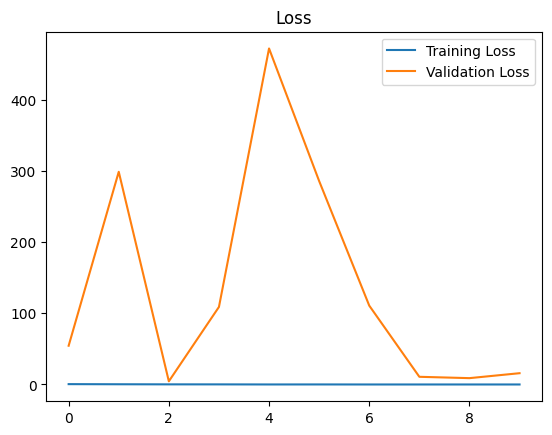

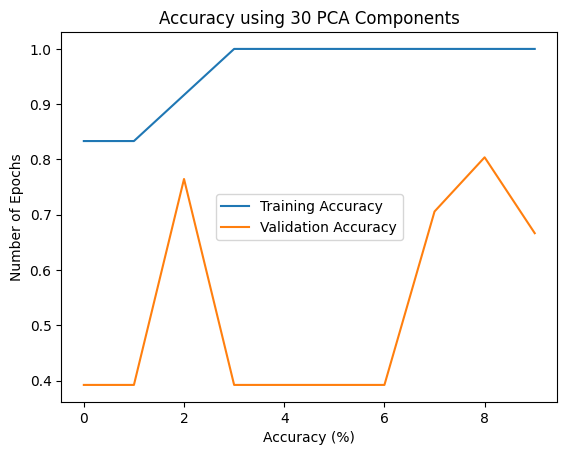

Accuracy using 30 PCA Components: 0.67%


In [24]:
cmpts = 30
history = model.history.history
acc = last = next(reversed(history.values()))
model_loss=pd.DataFrame(model.history.history)
plot_metrics(history, cmpts)
print("Accuracy using {:.0f} PCA Components: {:.2f}%".format(cmpts, acc[-1]))

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# Using all PCA components
x_reconstruction = x_reconstruction_all
y_train = y_train_all

model.fit(x=x_reconstruction, y=y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
7/7 [==============================] - 15s 2s/step - loss: 0.3739 - accuracy: 0.8713 - val_loss: 144.5234 - val_accuracy: 0.6078
Epoch 2/10
7/7 [==============================] - 12s 2s/step - loss: 0.0346 - accuracy: 1.0000 - val_loss: 80.3758 - val_accuracy: 0.6275
Epoch 3/10
7/7 [==============================] - 16s 2s/step - loss: 0.0744 - accuracy: 1.0000 - val_loss: 418.1443 - val_accuracy: 0.6078
Epoch 4/10
7/7 [==============================] - 17s 2s/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 85.5887 - val_accuracy: 0.6471
Epoch 5/10
7/7 [==============================] - 17s 3s/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 142.2573 - val_accuracy: 0.6078
Epoch 6/10
7/7 [==============================] - 16s 2s/step - loss: 8.1083e-04 - accuracy: 1.0000 - val_loss: 205.3796 - val_accuracy: 0.6078
Epoch 7/10
7/7 [==============================] - 13s 2s/step - loss: 3.9215e-04 - accuracy: 1.0000 - val_loss: 236.5447 - val_accuracy: 0.6078
Epoch 8/10
7/7

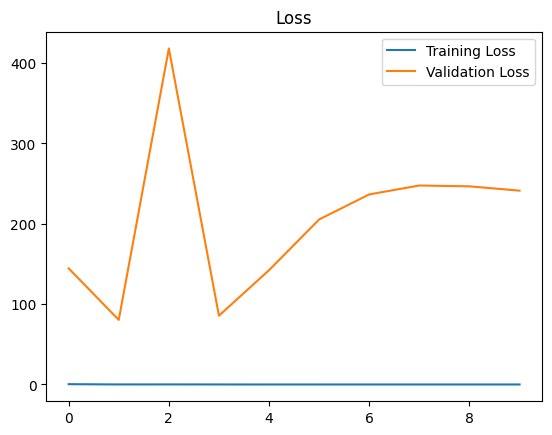

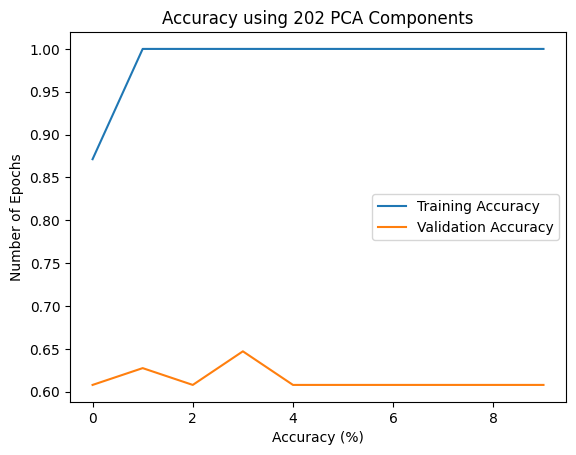

Accuracy using 202 PCA Components: 0.61%


In [27]:
cmpts = 202
history = model.history.history
acc = last = next(reversed(history.values()))
model_loss=pd.DataFrame(model.history.history)
plot_metrics(history, cmpts)
print("Accuracy using {:.0f} PCA Components: {:.2f}%".format(cmpts, acc[-1]))